In [ ]:
# default_exp models.transfermodels

# models.transfermodels

> API details.

In [ ]:
# export
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import torch
from torch import nn
from fastrenewables.tabular.model import *
from fastrenewables.timeseries.model import *
from fastai.tabular.all import *
from torch.autograd import Variable
from sklearn.datasets import make_regression
from fastai.learner import *
from fastrenewables.utils_pytorch import *
import copy


In [ ]:
def generate_single_dataset(n_samples, start, end, bias, coef, noise_factor=0.3):

    X = np.random.uniform(low=start, high=end,size=n_samples)
    y = np.sin(X*coef*2*np.pi) + np.random.randn(X.shape[0])*noise_factor+bias
    
    return X,y

In [ ]:
def generate_all_tasks(n_samples=100):
    starts = [0,  0]
    ends = [4.1,  3.9]
    coefs = [3.4,  4]
    biases = [0.1,  0.1]
    n_samples = [n_samples, 30]
    
    df_tasks = []
    for task_id in range(len(starts)):
        start, end, bias, coef = starts[task_id], ends[task_id], coefs[task_id], biases[task_id]
        X,y = generate_single_dataset(n_samples[task_id], start, end, bias, coef, noise_factor=0.05)
        df_task = pd.DataFrame({"X": X.ravel(), "y":y.ravel()})
        df_task["TaskID"] = task_id
        df_tasks.append(df_task)
    return pd.concat(df_tasks)

In [ ]:
def get_source_task(df):
    df_source =  df[df.TaskID == 0]
    dls = TabularDataLoaders.from_df(df_source, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    return dls
    
def get_target_task(df):
    df_target =  df[df.TaskID == 1]
    dls = TabularDataLoaders.from_df(df_target, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    return dls

In [ ]:
df = generate_all_tasks()

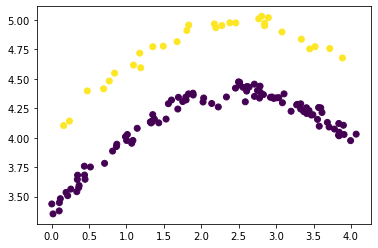

In [ ]:
plt.scatter(df.X, df.y, c=df.TaskID)

In [ ]:
dls_source = get_source_task(df)
dls_target = get_target_task(df)

In [ ]:
set_seed(10)
# set_random_states(10, 10,10, 10, 10, 10)
source_model = MultiLayerPerceptron([1, 100, 10, 5, 1], use_bn=True, bn_cont=False)
learn_source = Learner(dls_source, source_model, metrics=rmse)

In [ ]:
learn_source.fit(25, lr=0.01)

epoch,train_loss,valid_loss,_rmse,time
0,13.597255,13.528824,3.678155,00:00
1,12.917191,12.259760,3.501394,00:00
2,12.144095,10.202208,3.194089,00:00
3,11.197414,8.158646,2.856334,00:00
4,10.049754,5.973557,2.444086,00:00
5,8.753527,3.649786,1.910441,00:00
6,7.395007,1.605155,1.266947,00:00
7,6.088000,0.334882,0.578690,00:00
8,4.959925,0.052513,0.229157,00:00
9,4.046452,0.012820,0.113226,00:00


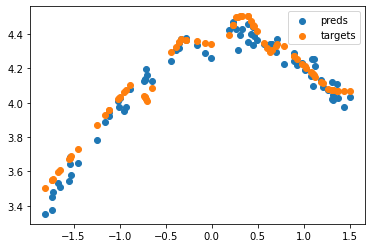

In [ ]:
targets, preds = learn_source.get_preds(ds_idx=0)
plt.scatter(dls_source.train_ds.items.X, preds, label="preds")
plt.scatter(dls_source.train_ds.items.X, targets, label="targets")
plt.legend()
plt.show()

In [ ]:
# hide
# export
def _create_matrices(n_features, alpha):
    w_mean = torch.zeros(n_features)
    w_precision = torch.eye(n_features) / alpha
    
    return w_mean, w_precision
# minimal check if we can create the matricies
mean, precision = _create_matrices(10, 10)
test_eq(0, mean.sum())
test_eq(0.1, precision[0,0])

In [ ]:
from fastrenewables.timeseries.model import *

In [ ]:
# export
class LinearTransferModel(nn.Module):
    def __init__(self, source_model, num_layers_to_remove=1, 
                 name_layers_or_function_to_remove="layers", use_original_weights=True,
                alpha=1, beta=1, include_original_features=False):
        super().__init__()
        self.are_weights_initialized = False
        self.alpha, self.beta = alpha, beta
        self.num_layers_to_remove = num_layers_to_remove
        self.ts_length = 1
        self.source_model = copy.deepcopy(source_model)
        
        
        if callable(name_layers_or_function_to_remove):
            name_layers_or_function_to_remove(self.source_model, num_layers_to_remove)
        elif type(name_layers_or_function_to_remove) == str:
            layers = getattrs(self.source_model, name_layers_or_function_to_remove, default=None)[0]
            if layers is None:
                raise ValueError(f"Could not find layers by given name {name_layers_or_function_to_remove}.")
            elif isinstance(layers, torch.nn.modules.container.Sequential):
                setattr(self.source_model, name_layers_or_function_to_remove, layers[0:-self.num_layers_to_remove])
            else:
                raise ValueError(f"Only sequential layers are supported.")
        else:
            ValueError("Unknown type for name_layers_or_function_to_remove")
            
        if num_layers_to_remove != 1 and use_original_weights:
            raise ValueError("Can only reuse weights when using the last layers due to the dimension.")
        elif num_layers_to_remove == 1 and use_original_weights:
            
            for element in layers[-1]:
                if isinstance(element, nn.Linear):
                    # create mean matrix including bias
                    self.w_mean = copy.copy(element.weight.data)
                    bias = copy.copy(element.bias.data)
                    self.w_mean = self.w_mean.reshape(self.w_mean.shape[1])
                    self.w_mean = torch.cat([bias, self.w_mean])
                    
                    # create precision and variance matrix
                    self.n_features = self.w_mean.shape[0]
                    _, self.w_precision = _create_matrices(self.n_features, self.alpha)
                    self.w_covariance = torch.linalg.inv(self.w_precision)
                    
                    self.are_weights_initialized = True
                    
            if not self.are_weights_initialized:
                raise ValueError(f"Could not find linear layer in last layer {self.layers[-1]}")
        
        
        freeze(self.source_model)
        self.include_original_features = include_original_features
        
        # fake param so that it can be used with pytorch trainers
        self.fake_param=nn.Parameter(torch.zeros((1,1), dtype=torch.float))
        self.fake_param.requires_grad =True
        
    def transform(self, cats, conts):
        n_samples = conts.shape[0]
        
        x_transformed =  self.source_model(cats, conts)
        
        # flatten and update n_samples in case of timeseries model
        x_transformed = x_transformed.reshape(n_samples*self.ts_length, -1)
        n_samples = x_transformed.shape[0]
        
        if self.include_original_features:
            x_transformed = torch.cat([ conts.reshape(n_samples,-1), x_transformed], axis=1)
        
        # add feature for bias
        x_transformed = torch.cat([ torch.ones(n_samples).reshape(n_samples,1), x_transformed], axis=1)
                
        return x_transformed
    
    def forward(self, cats, conts):
        n_samples = conts.shape[0]
        self.ts_length = 1
        if len(conts.shape) == 3:
            self.ts_length = conts.shape[2]
        
        x_transformed = self.transform(cats, conts) 
        
        if not self.are_weights_initialized:
            self.n_features = x_transformed.shape[1]#*self.ts_length

            self.w_mean, self.w_precision = _create_matrices(self.n_features, self.alpha)
            self.w_covariance = torch.linalg.inv(self.w_precision)
            self.are_weights_initialized=True
        
        if self.training:
            return x_transformed
        else:
            preds = self._predict(x_transformed)[0]
            
            return preds
            
    def _predict(self, X):
        # calcualte the predictive mean (Bishop eq. 3.58)
        y_pred_mean = X @ self.w_mean

        # calculate the predictive variance (Bishop eq. 3.59)
        y_pred_var = 1 / self.beta + (X @ self.w_covariance * X).sum(axis=1)

        # Drop a dimension from the mean and variance in case x and y were singletons
        y_pred_mean = torch.squeeze(y_pred_mean)
        y_pred_var = torch.squeeze(y_pred_var)

        return y_pred_mean, y_pred_var ** 0.5
    
    def update(self, X, y):
        """Update mean and precision. X needs to be the output of the original source model."""
        
        w_precision = self.w_precision + self.beta * X.T @ X
        
        w_covariance = torch.linalg.inv(w_precision)
        w_mean = w_covariance @ (self.w_precision @ self.w_mean + self.beta * y @ X)

        self.w_precision = w_precision
        self.w_covariance = torch.linalg.inv(w_precision)
        
        self.w_mean = w_mean
        
        return self


    def predict(self, cats, conts):
        x_transformed = self.transform(cats, conts) 
        y_pred_mean, _ = self._predict(x_transformed)

        return y_pred_mean

    def predict_proba(self, cats, conts):
        x_transformed = self.transform(cats, conts)
        y_pred_mean, y_pred_std = self._predict(x_transformed)

        return y_pred_mean, y_pred_std
    
    def loss_func(self, x_transformed, ys):
        
        _tmp = self.update(x_transformed, ys.ravel())
        
        fake_loss = torch.tensor([0], dtype=torch.float)
        fake_loss.requires_grad=True
        return self.fake_param + fake_loss
    
    
    def _log_prior(self, w):
        return -0.5 * self.alpha * torch.sum(w ** 2)

    def _log_likelihood(self, X, y, w):
        return -0.5 * self.beta * torch.square(y - X @ w).sum()


    def _log_posterior(self, X, y, w):
        return self._log_likelihood(X, y, w) + self._log_prior(w)

    def log_evidence(self, X, y):
        X, y = self._check_and_prep(X, y)

        N, M = X.shape
        
        # E(\mathbf{m}_n) = \beta/2 \cdot ||y- X \mathbf{m}_n|| + \alpha/2 \mathbf{m}_n^T \mathbf{m}_n, 
        # where \mathbf{m}_n is the mean weight. This is the same as the negative of the posterior       
        Emn = -self._log_posterior(X, y, self.w_mean)
        
        # Bishop eq. 3.86         
        return 0.5 * (M * np.log(self.alpha) + N * np.log(self.beta)
            - np.linalg.slogdet(self.w_precision)[1] - N * np.log(2 * np.pi)
        ) - Emn


In [ ]:
# hide
cats, conts, targets = dls_target.one_batch()
# test if we get the same results as with the original model
with torch.no_grad():
    
    preds_source = source_model(cats, conts).ravel()
    ltmodel = LinearTransferModel(source_model, num_layers_to_remove=1, use_original_weights=True)
    
    preds_target = ltmodel.predict(cats, conts)
    test_close(preds_source, preds_target)
    preds_target = ltmodel.predict(cats, conts)
    test_close(preds_source, preds_target)
    preds_target = ltmodel.predict_proba(cats, conts)[0]
    test_close(preds_source, preds_target)


In [ ]:
target_model = LinearTransferModel(source_model, num_layers_to_remove=1, 
                                   use_original_weights=True,
                                  alpha=0.001, beta=1000)
target_model = target_model.eval()

Create forecats and check if the source model and the untrained model create the same results

In [ ]:
cats, conts, targets = dls_source.one_batch()

In [ ]:
with torch.no_grad():
    preds_source = source_model(cats, conts).ravel()
preds_target = target_model(cats.to("cpu"), conts.to("cpu"))

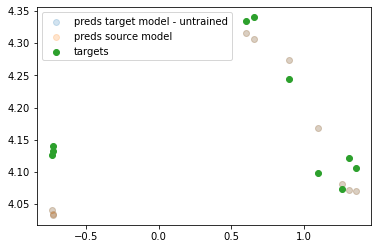

In [ ]:
# targets, preds = learn_source.get_preds(ds_idx=0)
plt.scatter(conts, preds_target, label="preds target model - untrained", alpha=0.2)
plt.scatter(conts, preds_source.detach(), label="preds source model", alpha=0.2)
plt.scatter(conts, targets, label="targets")

plt.legend()
plt.show()

In [ ]:
target_model = LinearTransferModel(source_model, num_layers_to_remove=1, 
                                   use_original_weights=True,
#                                   alpha=(1/0.1)**2, beta=(1/0.1)**2)
                                   alpha=10, beta=10)
target_model.training = True

In [ ]:
preds_before_training = []
conts_test_before_training = []
targets_before_training = []
for cats, conts, targets in dls_target[0]:
    target_model(cats, conts)
    pred_before_training = target_model.predict(cats, conts)
    preds_before_training.append(pred_before_training)
    conts_test_before_training.append(conts)
    targets_before_training.append(targets)
    
preds_before_training = torch.cat(preds_before_training)
conts_test_before_training = torch.cat(conts_test_before_training)
targets_before_training = torch.cat(targets_before_training)

In [ ]:
pred_before_training.shape, targets_before_training.shape

(torch.Size([10]), torch.Size([20, 1]))

In [ ]:
for cats, conts, targets in dls_target[0]:
    x_transformed = target_model.forward(cats, conts)
    target_model = target_model.update(x_transformed, targets.ravel())
#     x_transformed = target_model.forward(cats, torch.tensor(dls_target.train_ds.items.X.values).reshape(-1,1))
#     target_model = target_model.update(x_transformed, torch.tensor(dls_target.train_ds.items.y.values).ravel())


In [ ]:
preds_after_training = []
conts_test_after_training = []
targets_after_training = []
for cats, conts, targets in dls_target[0]:
    pred_after_training = target_model.predict(cats, conts)
    preds_after_training.append(pred_after_training)
    conts_test_after_training.append(conts)
    targets_after_training.append(targets)
    
preds_after_training = torch.cat(preds_after_training)
conts_test_after_training = torch.cat(conts_test_after_training)
targets_after_training = torch.cat(targets_after_training)

In [ ]:
((targets_after_training.reshape(-1)-preds_after_training.reshape(-1))**2).mean()**0.5

tensor(0.0628)

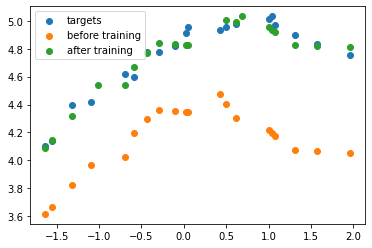

In [ ]:
plt.scatter(conts_test_before_training, targets_before_training, label="targets")
plt.scatter(conts_test_before_training, preds_before_training, label="before training")
plt.scatter(conts_test_after_training, preds_after_training, label="after training")
plt.legend()

Lets assure that it also works with pytorch trainings such as the fastai training loop

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=True,
                                   alpha=1/(0.1)**0.5, beta=1/(0.1)**0.5)


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,-0.002000,0.233920,00:00


We can also not using the last layer as initializaition

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=False,
                                   alpha=1/(0.1)**0.5, beta=1/(0.1)**0.5)


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,-0.002000,0.129076,00:00


Or remove multiple layers

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=2, 
                                   use_original_weights=False,
                                   alpha=1/(0.1)**0.5, beta=1/(0.1)**0.5)


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,-0.002000,0.133876,00:00


# Test on real world data

In [ ]:

from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastrenewables.tabular.learner import *

In [ ]:
cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
       'ASWDIRS_SFC_0_M', 'WindSpeed58m',
       'SinWindDirection58m', 'CosWindDirection58m', 'WindSpeed60m',
       'SinWindDirection60m', 'CosWindDirection60m', 'WindSpeed58mMinus_t_1',
       'SinWindDirection58mMinus_t_1', 'CosWindDirection58mMinus_t_1',
       'WindSpeed60mMinus_t_1', 'SinWindDirection60mMinus_t_1',
       'CosWindDirection60mMinus_t_1', 'WindSpeed58mPlus_t_1',
       'SinWindDirection58mPlus_t_1', 'CosWindDirection58mPlus_t_1',
       'WindSpeed60mPlus_t_1', 'SinWindDirection60mPlus_t_1',
       'CosWindDirection60mPlus_t_1']
cat_names = ['TaskID', 'Month', 'Day', 'Hour']

dls_source = RenewableDataLoaders.from_files(glob.glob("../data/*.h5")[0:1], y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), 
                                                 AddSeasonalFeatures(as_cont=False)], 
                                      cat_names=cat_names, cont_names=cont_names)

dls_target = RenewableDataLoaders.from_files(glob.glob("../data/*.h5")[2], y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), 
                                                 AddSeasonalFeatures(as_cont=False)], 
                                      cat_names=cat_names, cont_names=cont_names)

In [ ]:
learn_source = renewable_learner(dls_source, metrics=rmse)
learn_source.fit(10)

epoch,train_loss,valid_loss,_rmse,time
0,0.026344,0.018487,0.135966,00:00
1,0.016860,0.015592,0.124869,00:00
2,0.013994,0.014988,0.122424,00:00
3,0.013479,0.013282,0.115249,00:00
4,0.012488,0.013669,0.116914,00:01
5,0.012515,0.013215,0.114958,00:00
6,0.012388,0.013114,0.114515,00:00
7,0.011285,0.013015,0.114083,00:00
8,0.011318,0.012695,0.112672,00:00
9,0.010204,0.012120,0.110091,00:00


In [ ]:
target_model = LinearTransferModel(learn_source.model, 1, use_original_weights=True,
                                  alpha=1/(0.1)**0.5, beta=1/(0.1)**0.5)

In [ ]:
target_learner = RenewableLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.067663,-0.102946,0.098105,00:00


In [ ]:
preds, targets = target_learner.predict(ds_idx=1, filter=True, flatten=True)

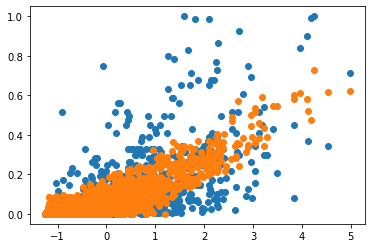

In [ ]:
plt.scatter(dls_target.valid_ds.items.WindSpeed58m, targets)
plt.scatter(dls_target.valid_ds.items.WindSpeed58m, preds)

## Test for timeseries

In [ ]:
from fastrenewables.timeseries.core import *
from fastrenewables.tabular.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *
from fastrenewables.timeseries.learner import *

In [ ]:
def get_dls(y_names="PowerGeneration"):
#     if cont_names is None:
#         cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
#            'ASWDIRS_SFC_0_M', 'WindSpeed58m', "HourSin", "HourCos"]
    
    pd.options.mode.chained_assignment=None
    dls_source = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[0], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[#FilterYear(year=2020), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    dls_target = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[1], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[FilterYear(year=2020), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    return dls_source, dls_target



In [ ]:
dls_source, dls_target = get_dls()

In [ ]:
n_features = len(dls_source.train_ds.cont_names)

In [ ]:
learner = renewable_timeseries_learner(dls_source, metrics=rmse, layers=[n_features, 200, 100, 50, 25, 5, 1])

In [ ]:
learner.fit_one_cycle(20)

epoch,train_loss,valid_loss,_rmse,time
0,0.042092,0.026910,0.164044,00:00
1,0.028721,0.015365,0.123955,00:00
2,0.021590,0.013102,0.114464,00:00
3,0.018228,0.012192,0.110415,00:00
4,0.016293,0.012858,0.113393,00:00
5,0.015048,0.014523,0.120511,00:00
6,0.014057,0.013996,0.118307,00:00
7,0.013323,0.015693,0.125270,00:01
8,0.012929,0.013321,0.115417,00:00
9,0.012528,0.013197,0.114876,00:00


In [ ]:
preds, targets = learner.predict(ds_idx=1, filter=True)

In [ ]:
dls_source.valid_ds.cont_names

(#23) ['T_HAG_2_M','RELHUM_HAG_2_M','PS_SFC_0_M','ASWDIFDS_SFC_0_M','ASWDIRS_SFC_0_M','WindSpeed58m','SinWindDirection58m','CosWindDirection58m','WindSpeed60m','SinWindDirection60m'...]

In [ ]:
id_ws = 5

We catch the the wind speed from the validation data to check the forecasts.

In [ ]:
windspeed = dls_source.valid_ds.conts[:,id_ws,:]
windspeed = windspeed.reshape(-1,1)

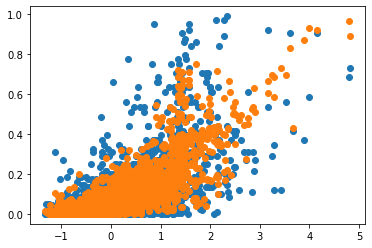

In [ ]:
plt.scatter(windspeed, targets)
plt.scatter(windspeed, preds)

In [ ]:
# export
def reduce_layers_tcn_model(tcn_model, num_layers=1):
    tcn_model.layers.temporal_blocks = tcn_model.layers.temporal_blocks[:-num_layers]

In [ ]:
target_model = LinearTransferModel(learner.model, 1, reduce_layers_tcn_model, use_original_weights=False,
                                  alpha=100, beta=100, include_original_features=True)

In [ ]:
target_learner = RenewableTimeseriesLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.012463,-0.023997,0.144655,00:00


In [ ]:
preds, targets = target_learner.predict(ds_idx=1, filter=True, flatten=True)

In [ ]:
preds.shape, targets.shape

((1728,), (1728,))

In [ ]:
windspeed = dls_target.valid_ds.conts[:,id_ws,:]
windspeed = windspeed.reshape(-1,1)

In [ ]:
windspeed.shape

torch.Size([1728, 1])

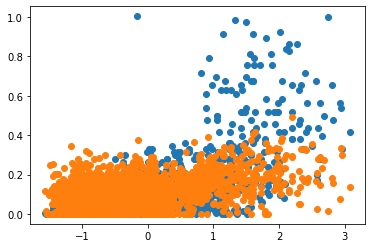

In [ ]:
plt.scatter(windspeed, targets)
plt.scatter(windspeed, preds)